In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## finetuning DINOv2 on REFUGE

In [ ]:

import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.transforms import (Compose, Resize, RandomHorizontalFlip,
    RandomVerticalFlip, ColorJitter, RandomRotation, RandomAffine, GaussianBlur,
    RandomResizedCrop, ToTensor, Normalize)
from PIL import Image
from tqdm import tqdm

# === CONFIG ===
GLAUCOMA_ROOT = "/content/drive/MyDrive/glaucoma_detection"
REFUGE_PATH = os.path.join(GLAUCOMA_ROOT, "unified_REFUGE")  # Only REFUGE dataset

# === HYPERPARAMETERS ===
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 3e-5
IMG_SIZE = 224

# === DEVICE ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === MODEL ===
dinov2 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14").to(device)
classifier_head = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(384, 2)
).to(device)  # 384 is the embed dim for dinov2_vits14

# === TRANSFORMS ===
common_transform = Compose([
    Resize((IMG_SIZE, IMG_SIZE)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Heavier data augmentation for better generalization
train_aug_transform = Compose([
    RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    RandomRotation(45),
    ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    GaussianBlur(3),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# === DATASET ===
class FundusDataset(Dataset):
    def __init__(self, folder, transform):
        self.samples = []
        self.transform = transform
        for label in ["GON+", "GON-"]:
            class_path = os.path.join(folder, label)
            if os.path.isdir(class_path):
                for f in os.listdir(class_path):
                    if f.lower().endswith((".jpg", ".jpeg", ".png")):
                        self.samples.append((os.path.join(class_path, f), 1 if label == "GON+" else 0))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("RGB")
        image = self.transform(image)
        return image, label

# Create full dataset and split
full_dataset = FundusDataset(REFUGE_PATH, transform=train_aug_transform)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# === OPTIMIZER ===
params = list(dinov2.parameters()) + list(classifier_head.parameters())
optimizer = torch.optim.AdamW(params, lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# === TRAIN LOOP ===
def train_one_epoch(epoch):
    dinov2.train()
    classifier_head.train()
    total_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}"):
        images, labels = images.to(device), labels.to(device)
        features = dinov2(images)
        logits = classifier_head(features)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(train_loader)

# === EVALUATION ===
def evaluate():
    dinov2.eval()
    classifier_head.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            features = dinov2(images)
            logits = classifier_head(features)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

# === TRAINING ===
best_acc = 0
patience = 5
counter = 0
for epoch in range(1, EPOCHS + 1):
    loss = train_one_epoch(epoch)
    acc = evaluate()
    print(f"Epoch {epoch}: Loss = {loss:.4f}, Val Accuracy = {acc:.4f}")
    if acc > best_acc:
        best_acc = acc
        counter = 0
        torch.save({
            'dinov2_state_dict': dinov2.state_dict(),
            'classifier_state_dict': classifier_head.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, os.path.join(GLAUCOMA_ROOT, "best_dinov2_classifier_refuge_only.pth"))
    else:
        counter += 1
    if counter >= patience:
        print("Early stopping triggered.")
        break

# Final model save
save_path = os.path.join(GLAUCOMA_ROOT, "dinov2_classifier_refuge_only_final.pth")
torch.save({
    'dinov2_state_dict': dinov2.state_dict(),
    'classifier_state_dict': classifier_head.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, save_path)
print(f"Model saved to {save_path}")


Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 283MB/s]


ValueError: num_samples should be a positive integer value, but got num_samples=0

In [ ]:
acc = evaluate()
print(f"REFUGE Test Accuracy: {acc:.4f}")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_test_results():
    dinov2.eval()
    classifier_head.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = classifier_head(dinov2(images))
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels.numpy())

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=["GON-", "GON+"]))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["GON-", "GON+"], yticklabels=["GON-", "GON+"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("REFUGE Test Set - Confusion Matrix")
    plt.show()

evaluate_test_results()


## Finetuning on DRISHTI-GS

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.transforms import (Compose, Resize, RandomHorizontalFlip,
    RandomVerticalFlip, ColorJitter, ToTensor, Normalize, RandomResizedCrop,
    GaussianBlur, RandomAffine)
from PIL import Image
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === CONFIG ===
GLAUCOMA_ROOT = "/content/drive/MyDrive/glaucoma_detection"
DRISHTI_PATH = os.path.join(GLAUCOMA_ROOT, "unified_DRISHTI-GS")

# === HYPERPARAMETERS ===
BATCH_SIZE = 64
EPOCHS = 50
IMG_SIZE = 224
LEARNING_RATE = 1e-5
CLASSIFIER_LR = 3e-4
BLUR_THRESHOLD = 10.0
AUG_PER_IMAGE = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === BLUR FILTER ===
def is_blurry(image_np, threshold=15.0):
    gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var() < threshold

# === BASE DATASET WITH BLUR FILTER ===
class FundusDataset(Dataset):
    def __init__(self, folder, transform=None, blur_threshold=15.0):
        self.samples = []
        self.transform = transform
        self.label_counts = [0, 0]
        dropped = 0

        for label in ["GON+", "GON-"]:
            class_path = os.path.join(folder, label)
            if os.path.isdir(class_path):
                for f in os.listdir(class_path):
                    if f.lower().endswith((".jpg", ".jpeg", ".png")):
                        path = os.path.join(class_path, f)
                        try:
                            img = Image.open(path).convert("RGB")
                            img_np = np.array(img)
                            if not is_blurry(img_np, threshold=blur_threshold):
                                self.samples.append((path, 1 if label == "GON+" else 0))
                                self.label_counts[1 if label == "GON+" else 0] += 1
                            else:
                                dropped += 1
                        except Exception as e:
                            print(f"Error with {path}: {e}")
        print(f"Filtered blurry images: {dropped}")
        print(f"Post-filter class counts: GON-={self.label_counts[0]}, GON+={self.label_counts[1]}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# === AUGMENTED DATASET ===
class AugmentedFundusDataset(Dataset):
    def __init__(self, full_dataset, indices, augmentations_per_image=10):
        self.augmentations_per_image = augmentations_per_image
        self.transform = train_aug_transform
        self.expanded_samples = []

        for idx in indices:
            path, label = full_dataset.samples[idx]
            for _ in range(augmentations_per_image):
                self.expanded_samples.append((path, label))

    def __len__(self):
        return len(self.expanded_samples)

    def __getitem__(self, idx):
        path, label = self.expanded_samples[idx]
        image = Image.open(path).convert("RGB")
        image = self.transform(image)
        return image, label

# === TRANSFORMS ===
common_transform = Compose([
    Resize((IMG_SIZE, IMG_SIZE)),
    ToTensor(),
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

train_aug_transform = Compose([
    RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0)),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    ColorJitter(0.3, 0.3, 0.3, 0.1),
    GaussianBlur(3),
    RandomAffine(degrees=15, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    ToTensor(),
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# === LOAD DATA ===
full_dataset = FundusDataset(DRISHTI_PATH, transform=None, blur_threshold=BLUR_THRESHOLD)
labels = [label for _, label in full_dataset.samples]
train_idx, test_idx = train_test_split(np.arange(len(labels)), test_size=0.2, stratify=labels, random_state=42)

augmented_train_dataset = AugmentedFundusDataset(full_dataset, train_idx, augmentations_per_image=AUG_PER_IMAGE)
test_dataset = Subset(FundusDataset(DRISHTI_PATH, transform=common_transform, blur_threshold=BLUR_THRESHOLD), test_idx)

train_loader = DataLoader(augmented_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Base train images: {len(train_idx)}")
print(f"Augmented train images: {len(augmented_train_dataset)}")

# === MODEL ===
dinov2 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14").to(device)
for param in dinov2.parameters():
    param.requires_grad = True

classifier_head = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(384, 2)
).to(device)

optimizer = torch.optim.AdamW([
    {'params': dinov2.parameters(), 'lr': LEARNING_RATE},
    {'params': classifier_head.parameters(), 'lr': CLASSIFIER_LR}
])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

weights = 1. / torch.tensor(full_dataset.label_counts, dtype=torch.float)
criterion = nn.CrossEntropyLoss(weight=weights.to(device), label_smoothing=0.1)

# === TRAINING LOOP ===
def train_one_epoch(epoch):
    dinov2.train()
    classifier_head.train()
    total_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}"):
        images, labels = images.to(device), labels.to(device)
        features = dinov2(images)
        features = nn.functional.normalize(features, dim=1)
        logits = classifier_head(features)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate():
    dinov2.eval()
    classifier_head.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            features = dinov2(images)
            features = nn.functional.normalize(features, dim=1)
            logits = classifier_head(features)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

def evaluate_detailed():
    dinov2.eval()
    classifier_head.eval()
    y_true, y_pred = [], []
    misclassified = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            features = dinov2(images)
            features = nn.functional.normalize(features, dim=1)
            logits = classifier_head(features)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels.numpy())
            for i, (pred, true) in enumerate(zip(preds, labels)):
                if pred != true:
                    misclassified.append((images[i].cpu(), pred, true))

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=["GON-", "GON+"]))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["GON-", "GON+"], yticklabels=["GON-", "GON+"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    if misclassified:
        print("\nSample Misclassified Images:")
        fig, axs = plt.subplots(1, min(5, len(misclassified)), figsize=(15, 5))
        for ax, (img, pred, true) in zip(axs, misclassified[:5]):
            img = img.permute(1, 2, 0).numpy()
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)
            ax.imshow(img)
            ax.set_title(f"P: GON{'+' if pred==1 else '-'}\nT: GON{'+' if true==1 else '-'}")
            ax.axis("off")
        plt.tight_layout()
        plt.show()

# === MAIN TRAINING ===
best_acc = 0
patience = 5
counter = 0
for epoch in range(1, EPOCHS + 1):
    loss = train_one_epoch(epoch)
    acc = evaluate()
    scheduler.step(acc)
    print(f"Epoch {epoch}: Loss = {loss:.4f}, Val Accuracy = {acc:.4f}")
    if acc > best_acc:
        best_acc = acc
        counter = 0
        torch.save({
            'dinov2_state_dict': dinov2.state_dict(),
            'classifier_state_dict': classifier_head.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, os.path.join(GLAUCOMA_ROOT, "best_dinov2_classifier_drishti_augmented.pth"))
    else:
        counter += 1
    if counter >= patience:
        print("Early stopping triggered.")
        break

# === FINAL SAVE & EVAL ===
final_path = os.path.join(GLAUCOMA_ROOT, "dinov2_classifier_drishti_augmented_final.pth")
torch.save({
    'dinov2_state_dict': dinov2.state_dict(),
    'classifier_state_dict': classifier_head.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, final_path)
print(f"Final model saved to {final_path}")

evaluate_detailed()


## finetuning on eyepac-lightv2

In [ ]:
# === MODIFIED VERSION: No augmentation, tuned hyperparameters ===

import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import cv2
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === CONFIG ===
DriveSavePath = "/content/drive/MyDrive/glaucoma_detection"
DatasetRoot = "/content/drive/MyDrive/glaucoma_detection/datasets/eyepac-light-v2-512-jpg"

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 3e-5
CLASSIFIER_LR = 1e-4
BLUR_THRESHOLD = 15.0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# === SEED FOR REPRODUCIBILITY ===
def seed_everything(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything(42)

# === BLUR FILTER ===
def is_blurry(image_np, threshold=15.0):
    gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var() < threshold

# === TRANSFORMS ===
common_transform = Compose([
    Resize((IMG_SIZE, IMG_SIZE)),
    ToTensor(),
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# === DATASET CLASS ===
class AirogsFolderDataset(Dataset):
    def __init__(self, root_path, split, transform=None, blur_threshold=15.0):
        self.samples = []
        self.transform = transform
        self.label_counts = [0, 0]
        folder = os.path.join(root_path, split)
        for class_name in ["NRG", "RG"]:
            label = 0 if class_name == "NRG" else 1
            class_dir = os.path.join(folder, class_name)
            for fname in os.listdir(class_dir):
                if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                    path = os.path.join(class_dir, fname)
                    try:
                        image = Image.open(path).convert("RGB")
                        if not is_blurry(np.array(image), threshold=blur_threshold):
                            self.samples.append((path, label))
                            self.label_counts[label] += 1
                    except:
                        continue
        print(f"[{split.upper()}] Loaded {len(self.samples)} | GON-: {self.label_counts[0]} | GON+: {self.label_counts[1]}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# === LOAD DATASETS ===
train_dataset = AirogsFolderDataset(DatasetRoot, "train", transform=common_transform)
val_dataset = AirogsFolderDataset(DatasetRoot, "validation", transform=common_transform)
test_dataset = AirogsFolderDataset(DatasetRoot, "test", transform=common_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# === LOAD DINOV2 ===
dinov2 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14").to(device)
for param in dinov2.parameters():
    param.requires_grad = True

classifier_head = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(384, 2)
).to(device)

optimizer = torch.optim.AdamW([
    {'params': dinov2.parameters(), 'lr': LEARNING_RATE},
    {'params': classifier_head.parameters(), 'lr': CLASSIFIER_LR}
])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

weights = 1. / torch.tensor(train_dataset.label_counts, dtype=torch.float)
criterion = nn.CrossEntropyLoss(weight=weights.to(device), label_smoothing=0.1)

# === TRAINING ===
def train_one_epoch(epoch):
    dinov2.train()
    classifier_head.train()
    total_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}"):
        images, labels = images.to(device), labels.to(device)
        features = dinov2(images)
        features = nn.functional.normalize(features, dim=1)
        logits = classifier_head(features)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate(loader):
    dinov2.eval()
    classifier_head.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            features = dinov2(images)
            features = nn.functional.normalize(features, dim=1)
            logits = classifier_head(features)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

def evaluate_detailed(loader, name="Validation"):
    dinov2.eval()
    classifier_head.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            features = dinov2(images)
            features = nn.functional.normalize(features, dim=1)
            logits = classifier_head(features)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels.numpy())
    print(f"\n{name} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=["GON-", "GON+"]))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["GON-", "GON+"], yticklabels=["GON-", "GON+"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{name} Confusion Matrix")
    plt.show()

# === TRAIN LOOP ===
best_acc = 0
counter = 0
os.makedirs(DriveSavePath, exist_ok=True)

for epoch in range(1, EPOCHS + 1):
    loss = train_one_epoch(epoch)
    acc = evaluate(val_loader)
    scheduler.step(acc)
    print(f"Epoch {epoch}: Loss = {loss:.4f}, Val Accuracy = {acc:.4f}")
    if acc > best_acc:
        best_acc = acc
        counter = 0
        torch.save({
            'dinov2_state_dict': dinov2.state_dict(),
            'classifier_state_dict': classifier_head.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, os.path.join(DriveSavePath, "best_dinov2_classifier_airogs.pth"))
    else:
        counter += 1
    if counter >= 5:
        print("Early stopping triggered.")
        break

# === FINAL SAVE & EVALUATION ===
torch.save({
    'dinov2_state_dict': dinov2.state_dict(),
    'classifier_state_dict': classifier_head.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, os.path.join(DriveSavePath, "final_dinov2_classifier_airogs.pth"))

print("\u2705 Final model saved!")
evaluate_detailed(val_loader, name="Validation")
evaluate_detailed(test_loader, name="Test")


## finetuning on HYGD

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === CONFIG ===
HYGD_ROOT = "/content/drive/MyDrive/glaucoma_detection/hillel-yaffe-glaucoma-dataset-hygd-a-gold-standard-annotated-fundus-dataset-for-glaucoma-detection-1.0.0"
IMG_DIR = os.path.join(HYGD_ROOT, "images")
LABEL_CSV = os.path.join(HYGD_ROOT, "Labels.csv")

IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 1e-5
CLASSIFIER_LR = 3e-4

# === DEVICE ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === TRANSFORMS ===
common_transform = Compose([
    Resize((IMG_SIZE, IMG_SIZE)),
    ToTensor(),
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# === DATASET CLASS ===
class HYGD_Dataset(Dataset):
    def __init__(self, csv_path, image_dir, transform=None):
        df = pd.read_csv(csv_path)
        print("📄 CSV Columns:", df.columns.tolist())

        self.samples = []
        self.label_counts = [0, 0]
        self.transform = transform

        for _, row in df.iterrows():
            fname = str(row['Image Name']).strip()
            label_raw = str(row['Label']).strip().upper()
            label = 1 if label_raw == "GON+" else 0
            path = os.path.join(image_dir, fname)

            if not os.path.exists(path):
                print(f"❌ File not found: {path}")
                continue

            try:
                image = Image.open(path).convert("RGB")
                self.samples.append((path, label))
                self.label_counts[label] += 1
            except Exception as e:
                print(f"❌ Error reading {path}: {e}")

        print(f"✅ Loaded: {len(self.samples)} | GON-: {self.label_counts[0]} | GON+: {self.label_counts[1]}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# === MODEL SAVING UTILITY ===
def save_model(dinov2, classifier_head, optimizer, acc, path):
    torch.save({
        'dinov2_state_dict': dinov2.state_dict(),
        'classifier_state_dict': classifier_head.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_accuracy': acc
    }, path)
    print(f"💾 Saved model to: {path} | 🔍 Val Acc: {acc:.4f}")

# === LOAD DATASET ===
full_base = HYGD_Dataset(LABEL_CSV, IMG_DIR, transform=common_transform)
if len(full_base) == 0:
    raise ValueError("❌ No images loaded. Check file paths or CSV labels.")

train_len = int(0.8 * len(full_base))
val_len = len(full_base) - train_len
train_base, val_base = random_split(full_base, [train_len, val_len], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_base, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_base, batch_size=BATCH_SIZE, shuffle=False)

# === MODEL ===
dinov2 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14").to(device)
for param in dinov2.parameters():
    param.requires_grad = True

classifier_head = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(384, 2)
).to(device)

optimizer = torch.optim.AdamW([
    {'params': dinov2.parameters(), 'lr': LEARNING_RATE},
    {'params': classifier_head.parameters(), 'lr': CLASSIFIER_LR}
])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

weights = 1. / torch.tensor(full_base.label_counts, dtype=torch.float)
criterion = nn.CrossEntropyLoss(weight=weights.to(device), label_smoothing=0.1)

# === TRAINING ===
def train_one_epoch(epoch):
    dinov2.train()
    classifier_head.train()
    total_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}"):
        images, labels = images.to(device), labels.to(device)
        features = dinov2(images)
        features = nn.functional.normalize(features, dim=1)
        logits = classifier_head(features)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate():
    dinov2.eval()
    classifier_head.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            features = dinov2(images)
            features = nn.functional.normalize(features, dim=1)
            logits = classifier_head(features)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

def evaluate_detailed():
    dinov2.eval()
    classifier_head.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            features = dinov2(images)
            features = nn.functional.normalize(features, dim=1)
            logits = classifier_head(features)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels.numpy())
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=["GON-", "GON+"]))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["GON-", "GON+"], yticklabels=["GON-", "GON+"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# === TRAIN LOOP ===
best_acc = 0
counter = 0
for epoch in range(1, EPOCHS + 1):
    loss = train_one_epoch(epoch)
    acc = evaluate()
    scheduler.step(acc)
    print(f"📈 Epoch {epoch} | Loss: {loss:.4f} | Val Acc: {acc:.4f}")

    latest_path = os.path.join(HYGD_ROOT, "dinov2_classifier_hygd_latest.pth")
    save_model(dinov2, classifier_head, optimizer, acc, latest_path)

    if acc > best_acc:
        best_acc = acc
        counter = 0
        best_path = os.path.join(HYGD_ROOT, "best_dinov2_classifier_hygd.pth")
        save_model(dinov2, classifier_head, optimizer, acc, best_path)
    else:
        counter += 1

    if counter >= 5:
        print("🛑 Early stopping triggered.")
        break

# === FINAL EVAL ===
evaluate_detailed()


## resnet classifier

In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset root path
ROOT_DIR = "/content/drive/MyDrive/glaucoma_detection/resnet_classifier"

# Class mapping
CLASS_MAP = {
    "resnet_dhristhi": 0,
    "resnet_eyepacs": 1,
    "resnet_hygd": 2,
    "resnet_refuge": 3
}

# Reverse map for labels
IDX_TO_CLASS = {v: k for k, v in CLASS_MAP.items()}

# Image transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Custom Dataset
class GlaucomaDatasetBySource(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform

        for dataset_name, label in CLASS_MAP.items():
            dataset_path = os.path.join(root_dir, dataset_name)
            print(f"🔍 Searching in: {dataset_path}")
            for root, _, files in os.walk(dataset_path):
                for file in files:
                    if file.lower().endswith((".png", ".jpg", ".jpeg")):
                        full_path = os.path.join(root, file)
                        self.samples.append((full_path, label))

        print(f"✅ Total images loaded: {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Dataset and loader
dataset = GlaucomaDatasetBySource(ROOT_DIR, transform=transform)

if len(dataset) == 0:
    raise ValueError("🚫 No images found. Check folder paths and image extensions.")

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# ResNet Classifier (modern weights call)
from torchvision.models import resnet18, ResNet18_Weights

class DatasetClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super(DatasetClassifier, self).__init__()
        self.model = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

model = DatasetClassifier(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for i, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if i % 10 == 0:
            print(f"[Epoch {epoch+1} | Batch {i}] Loss: {loss.item():.4f}")

    avg_loss = running_loss / len(train_loader)
    print(f"📘 Epoch [{epoch+1}/{epochs}] - Avg Loss: {avg_loss:.4f}")

# Save the model
torch.save(model.state_dict(), os.path.join(ROOT_DIR, "dataset_classifier_resnet18.pth"))

# Visualization
def visualize_predictions(model, dataset, idx_to_class, n=5):
    model.eval()
    fig, axs = plt.subplots(1, n, figsize=(15, 5))
    for i in range(n):
        index = random.randint(0, len(dataset) - 1)
        image, label = dataset[index]
        input_tensor = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_tensor)
            pred = torch.argmax(output, dim=1).item()
        axs[i].imshow(transforms.ToPILImage()(image))
        axs[i].axis('off')
        axs[i].set_title(f"Pred: {idx_to_class[pred]}\nTrue: {idx_to_class[label]}")
    plt.tight_layout()
    plt.show()

# Show predictions
visualize_predictions(model, val_dataset, IDX_TO_CLASS, n=5)

## EOMT classifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%%capture
!pip install --upgrade git+https://github.com/huggingface/transformers
!pip install pillow matplotlib
import torch
print('CUDA available:', torch.cuda.is_available())

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# from transformers import AutoImageProcessor, EomtForUniversalSegmentation
# import torch

# model_id = 'tue-mps/ade20k_semantic_eomt_large_512'
# processor = AutoImageProcessor.from_pretrained(model_id)
# model = EomtForUniversalSegmentation.from_pretrained(model_id).to('cuda')
# model.eval()

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from transformers import AutoImageProcessor, EomtForUniversalSegmentation
from torch.cuda.amp import autocast, GradScaler


In [ ]:
# ---------------------- CLASSIFIER HEAD ----------------------
class ClassifierHead(torch.nn.Module):
    def __init__(self, in_dim=1024, num_classes=2):
        super().__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(in_dim, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(512, num_classes)
        )
    def forward(self, x):
        return self.fc(x)

In [ ]:
# ---------------------- STEP 1: Filter images using Laplacian Variance ----------------------
def laplacian_variance(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    return cv2.Laplacian(img, cv2.CV_64F).var()

def filter_images(root_dir, blur_thresh=15.0):
    valid_images, rejected_images = [], []
    for class_dir in ['GON+', 'GON-', 'RG', 'NRG']:
        path = os.path.join(root_dir, class_dir)
        if not os.path.exists(path): continue
        for img_path in glob(os.path.join(path, '*.jpg')):
            try:
                var = laplacian_variance(img_path)
                if var >= blur_thresh:
                    valid_images.append((img_path, class_dir))
                else:
                    rejected_images.append((img_path, class_dir, var))
            except:
                continue
    return valid_images, rejected_images

def create_metadata(filtered_images):
    data = []
    for path, label in filtered_images:
        gon_label = 1 if label in ['GON+', 'RG'] else 0
        data.append({'image_path': path, 'label': gon_label})
    return pd.DataFrame(data)

In [ ]:
# ---------------------- STEP 2: Dataset and Transforms ----------------------
def get_transforms():
    return A.Compose([
        A.Resize(512,512), A.HorizontalFlip(p=0.5), A.RandomBrightnessContrast(p=0.5),
        A.Rotate(limit=15, p=0.5), A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ToTensorV2()
    ])

class GlaucomaSegmentationDataset(Dataset):
    def __init__(self, metadata_df, transform=None):
        self.df = metadata_df
        self.transform = transform

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = np.array(Image.open(row['image_path']).convert("RGB"))
        label = row['label']
        if self.transform:
            augmented = self.transform(image=img)
            img = augmented['image']
        return img, torch.tensor(label).long()

    def __len__(self):
        return len(self.df)

In [ ]:
# ---------------------- STEP 3: Load EoMT Model ----------------------
def load_eomt_model():
    model_id = 'tue-mps/ade20k_semantic_eomt_large_512'
    processor = AutoImageProcessor.from_pretrained(model_id)
    model = EomtForUniversalSegmentation.from_pretrained(model_id)
    return model, processor


In [ ]:
# ---------------------- STEP 4: Prepare Data and Dataloaders ----------------------
def prepare_all_datasets(root_dirs, blur_thresh=15.0):
    all_images, rejected_all = [], []
    for root in root_dirs:
        filtered, rejected = filter_images(root, blur_thresh)
        all_images += filtered
        rejected_all += rejected

    meta_df = create_metadata(all_images)
    train_df, val_df = train_test_split(meta_df, test_size=0.2, stratify=meta_df['label'])
    transform = get_transforms()
    train_ds = GlaucomaSegmentationDataset(train_df, transform)
    val_ds = GlaucomaSegmentationDataset(val_df, transform)

    print(f"Total Accepted Images: {len(all_images)}")
    print(f"Total Rejected Images: {len(rejected_all)}")
    pd.DataFrame(rejected_all, columns=['image_path', 'class', 'laplacian_variance']).to_csv("rejected_blur_images.csv", index=False)
    return train_ds, val_ds, meta_df


In [ ]:
# ---------------------- STEP 5: Visualize Example ----------------------
def visualize_sample(dataset):
    img, label = dataset[0]
    img_np = img.permute(1, 2, 0).numpy()
    plt.figure(figsize=(6, 6))
    plt.imshow((img_np * 0.5 + 0.5).clip(0, 1))
    plt.title(f"Label: {'GON+' if label == 1 else 'GON-'}\nShape: {img_np.shape}")
    plt.axis('off')
    plt.show()

In [ ]:
# ---------------------- STEP 6: Fine-tune EoMT ----------------------
def train_eomt(model, classifier_head, train_loader, val_loader, num_epochs=15, save_path="best_eomt.pth"):
    model.to(device)
    classifier_head.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW([
        {"params": model.parameters(), "lr": 1e-5},
        {"params": classifier_head.parameters(), "lr": 5e-4}
    ])
    scaler = GradScaler()
    best_val_acc = 0

    for epoch in range(num_epochs):
        model.train(); classifier_head.train()
        running_loss, correct, total = 0, 0, 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.amp.autocast('cuda'):
                outputs = model(pixel_values=imgs, output_hidden_states=True)
                features = outputs.hidden_states[-1].mean(dim=1)
                logits = classifier_head(features)
                loss = criterion(logits, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {running_loss:.4f} | Train Acc: {train_acc:.4f}")

        model.eval(); classifier_head.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(pixel_values=imgs, output_hidden_states=True)
                features = outputs.hidden_states[-1].mean(dim=1)
                logits = classifier_head(features)
                preds = torch.argmax(logits, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        print(f"Validation Accuracy: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'model_state_dict': model.state_dict(),
                'classifier_state_dict': classifier_head.state_dict()
            }, save_path)
            print("Saved best model.")

In [ ]:
# ---------------------- STEP 7: Evaluate Model & Visualize Segmentation ----------------------
def evaluate_model(model, classifier_head, val_loader):
    model.to(device); classifier_head.to(device)
    model.eval(); classifier_head.eval()
    y_true, y_pred, y_scores = [], [], []
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc="Evaluating"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(pixel_values=imgs, output_hidden_states=True)
            features = outputs.hidden_states[-1].mean(dim=1)
            logits = classifier_head(features)
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            y_true.extend(labels.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())
            y_scores.extend(probs[:, 1].cpu().tolist())

    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.savefig("confusion_matrix.png")
    plt.show()

    auc = roc_auc_score(y_true, y_scores)
    print(f"ROC AUC Score: {auc:.4f}")

Total Accepted Images: 8974
Total Rejected Images: 186


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Train size: 7179, Val size: 1795


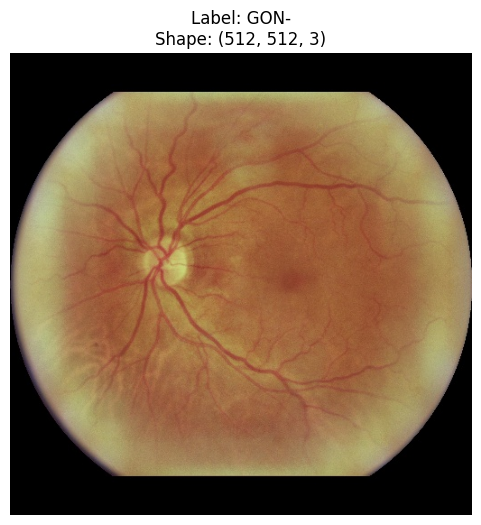

/tmp/ipython-input-13-4238933486.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/15 | Loss: 2491.6941 | Train Acc: 0.5453
Validation Accuracy: 0.5983
Saved best model.
Epoch 2/15 | Loss: 2395.9130 | Train Acc: 0.6143
Validation Accuracy: 0.6256
Saved best model.
Epoch 3/15 | Loss: 2340.2698 | Train Acc: 0.6291
Validation Accuracy: 0.6435
Saved best model.
Epoch 4/15 | Loss: 2218.8495 | Train Acc: 0.6565
Validation Accuracy: 0.6646
Saved best model.
Epoch 5/15 | Loss: 2127.9595 | Train Acc: 0.6717
Validation Accuracy: 0.6914
Saved best model.
Epoch 6/15 | Loss: 2048.4045 | Train Acc: 0.6947
Validation Accuracy: 0.7220
Saved best model.
Epoch 7/15 | Loss: 1979.5503 | Train Acc: 0.7100
Validation Accuracy: 0.7153
Epoch 8/15 | Loss: 1922.0052 | Train Acc: 0.7238
Validation Accuracy: 0.7398
Saved best model.
Epoch 9/15 | Loss: 1837.1670 | Train Acc: 0.7405
Validation Accuracy: 0.7142
Epoch 10/15 | Loss: 1757.1208 | Train Acc: 0.7586
Validation Accuracy: 0.7465
Saved best model.
Epoch 11/15 | Loss: 1694.5681 | Train Acc: 0.7693
Validation Accuracy: 0.7727
Saved b

Evaluating: 100%|██████████| 898/898 [01:35<00:00,  9.42it/s]



Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.81      0.83       850
           1       0.84      0.88      0.86       945

    accuracy                           0.84      1795
   macro avg       0.84      0.84      0.84      1795
weighted avg       0.84      0.84      0.84      1795



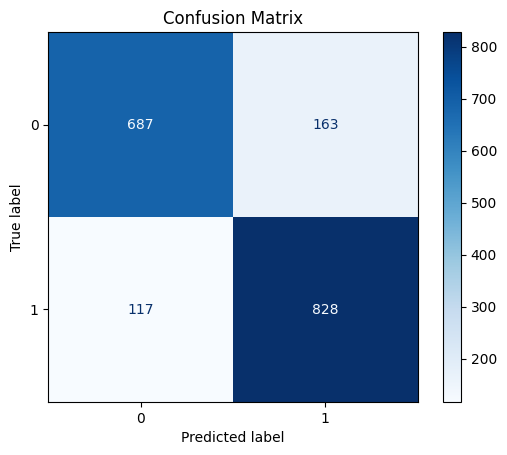

ROC AUC Score: 0.9274


In [ ]:
# ---------------------- MAIN EXECUTION ----------------------
if __name__ == "__main__":
    os.makedirs("seg_mask_vis", exist_ok=True)
    root_dirs = [
        "/content/drive/MyDrive/glaucoma_detection/resnet_classifier/resnet_dhristhi",
        "/content/drive/MyDrive/glaucoma_detection/resnet_classifier/resnet_eyepacs",
        "/content/drive/MyDrive/glaucoma_detection/resnet_classifier/resnet_refuge"
    ]
    train_ds, val_ds, metadata_df = prepare_all_datasets(root_dirs)
    model, processor = load_eomt_model()
    print(f"Train size: {len(train_ds)}, Val size: {len(val_ds)}")
    visualize_sample(train_ds)
    train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
    val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True)

    classifier_head = ClassifierHead().to(device)
    train_eomt(model, classifier_head, train_loader, val_loader)
    evaluate_model(model, classifier_head, val_loader)
    metadata_df.to_csv("filtered_glaucoma_metadata.csv", index=False)
